# One Pixel Attack Tutorial

![](images/horse.png "I'm a normal horse, nothing suspicious here") ![](images/horse-attack.png "I'm an attack horse, grr")

### Imports

In [1]:
# Python Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from keras.datasets import cifar10
from scipy.optimize import differential_evolution
from scipy.stats import truncnorm
from IPython.display import clear_output

/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Custom Networks
from networks.lecun_net import LecunNet
from networks.pure_cnn import PureCnn
from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet

from helper import get_class_names, plot_image, evaluate_models

In [3]:
matplotlib.style.use('ggplot')

### Load Data

Load the Cifar10 dataset and all necessary metadata.

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [5]:
# Obtain the names of the 10 classes in cifar10
class_names = get_class_names()
print(class_names)

Decoding file: data/batches.meta
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Load Models

Load various pretrained Neural Network models in the `networks/models` directory. There are more networks available, but must be trained before testing them here.

Keras will need to also download the Cifar10 dataset if it is not cached locally already.

In [6]:
lecun_net = LecunNet()
pure_cnn = PureCnn()
net_in_net = NetworkInNetwork()
resnet = ResNet()
densenet = DenseNet()
wide_resnet = WideResNet()

models = [lecun_net, pure_cnn, net_in_net, resnet, densenet, wide_resnet]

Successfully loaded lecun_net
Successfully loaded pure_cnn
Successfully loaded net_in_net
Successfully loaded resnet
Successfully loaded densenet
Successfully loaded wide_resnet


### Calculate Model Accuracies

In [7]:
network_stats, correct_imgs = evaluate_models(models, x_test, y_test)

correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

Testing lecun_net
Testing pure_cnn
Testing net_in_net
Testing resnet
Testing densenet
Testing wide_resnet


In [8]:
network_stats

,name,accuracy,param_count
0,lecun_net,0.7488,62006
1,pure_cnn,0.8877,1369738
2,net_in_net,0.9074,972658
3,resnet,0.9231,470218
4,densenet,0.9467,850606
5,wide_resnet,0.9534,11318026


### Image Perturbation

In [9]:
def perturb_image(x, img):
    img = np.copy(img)
    pixels = np.split(x.astype(int), len(x) // 5)
    for x in pixels:
        x_pos, y_pos, rgb = *x[:2], x[2:]
        img[x_pos][y_pos] = rgb
    return img

In [10]:
def predict_untargeted(x, *args):
    img, correct_class, model = args
    img_perturbed = perturb_image(x, img)
    prediction = model.predict_one(img_perturbed)
    return prediction[correct_class]

In [11]:
def predict_targeted(x, *args):
    img, target_class, model = args
    img_perturbed = perturb_image(x, img)
    prediction = model.predict_one(img_perturbed)
    return 1 - prediction[target_class]

### Untargeted Attack

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to minimize the probability of the correct classification category and maximize the sum of the probabilities of all other categories.

In [14]:
def attack_untargeted_iteration(img, model, pixel_count=1, iterations=30,
                                population=20, mutation=0.5, recombination=0.7, 
                                stop_threshold=-0.01, callback=None):
    print('Attacking image', img)
    
    args = x_test[img], y_test[img], model
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    attack = predict_untargeted

    cb = None if callback == None else lambda x,convergence: callback(x, convergence, args)
    disp = callback == None
    
    res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=1, atol=stop_threshold, disp=disp, callback=cb)

    attack_image = perturb_image(res.x, x_test[img])
    prior_probs = model.predict_one(x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_image]

In [15]:
def untargeted_callback(x, convergence, args):
    img, correct_class, model = args
    correct_class = correct_class[0]
    img_perturbed = perturb_image(x, img)
    confidence = model.predict_one(img_perturbed)
    prediction = np.argmax(confidence)
#     print('Confidence:', confidence[correct_class])
    if (prediction != correct_class):
        return True # Do it this way because returning it directly will prevent early halting

In [ ]:
_ = attack_untargeted_iteration(99, wide_resnet, pixel_count=3, callback=untargeted_callback)

In [ ]:
# def attack_iteration(img, model, target=None, pixel_count=1, iterations=30,
#                                 population=100, mutation=0.5, recombination=0.7, 
#                                 stop_threshold=-0.01, callback=None):
#     info = 'Attacking image ' + str(img)
#     info += ' with target ', target, class_names[target] if target else ''
#     print(info)
    
#     attack = predict_targeted if target else predict_untargeted
#     args = x_test[img], target, model if target else x_test[img], y_test[img], model
#     bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
#     cb = None if callback == None else lambda x,convergence: callback(x, convergence, args)
#     disp = callback == None
    
#     res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=1, atol=stop_threshold, disp=disp, callback=cb)

#     attack_image = perturb_image(res.x, x_test[img])
#     predicted_probs = model.predict_one(attack_image)
#     predicted_class = np.argmax(predicted_probs)
#     actual_class = y_test[img][0]
#     success = predicted_class != actual_class

#     plot_image(attack_image, actual_class, class_names, predicted_class)

#     return [img, actual_class, predicted_class, success, predicted_probs, attack_image]

In [ ]:
def attack_untargeted(model, pixel_count=1, sample_count=100, iterations=30,
                      population=20, mutation=0.5, recombination=1, 
                      stop_threshold=-0.01, callback=untargeted_callback):
    print('Targeting model', model.name, '-', pixel, 'pixels')
    
    samples = np.random.choice(len(x_test), sample_count)
    
    results = []
    for i,img in enumerate(samples):
        print('Sample', i)
        result = 
        results.append(result)
        print()
    
    return results

In [22]:
list(correct_imgs[correct_imgs.name == 'lecun_net'].img)

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 11,
 13,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 26,
 27,
 28,
 29,
 30,
 31,
 34,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 54,
 55,
 57,
 60,
 62,
 64,
 65,
 66,
 67,
 68,
 69,
 71,
 72,
 73,
 75,
 78,
 79,
 80,
 81,
 82,
 83,
 86,
 88,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 130,
 131,
 133,
 134,
 136,
 137,
 140,
 141,
 142,
 144,
 146,
 149,
 151,
 152,
 153,
 154,
 156,
 157,
 159,
 160,
 161,
 162,
 163,
 165,
 166,
 167,
 168,
 169,
 170,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 187,
 189,
 191,
 192,
 193,
 195,
 196,
 197,
 198,
 199,
 202,
 203,
 204,
 205,
 206,
 207,
 208,
 209,
 212,
 213,
 215,
 216,
 217,
 218,
 219,
 222,
 225,
 226,
 227,
 229,
 230,
 231,
 233,
 234,
 2

Attacking image 2118


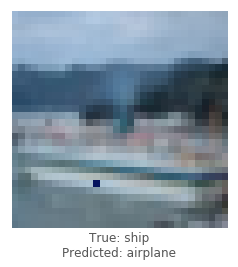

Attacking image 2863


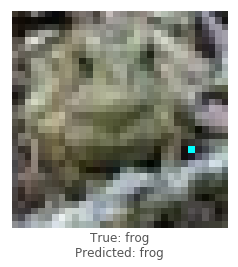

Attacking image 1264


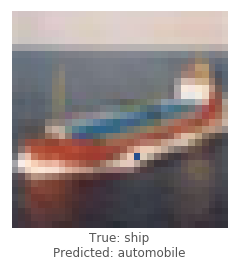

Attacking image 532


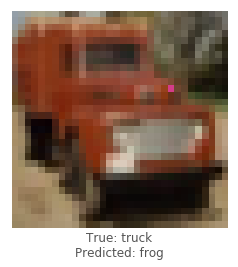

Attacking image 3610


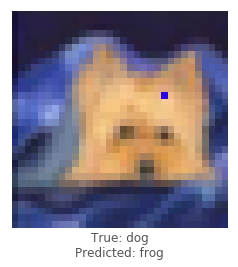

Attacking image 726


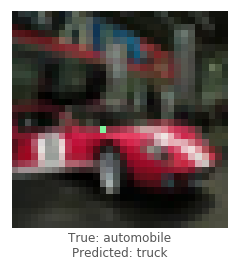

Attacking image 3042


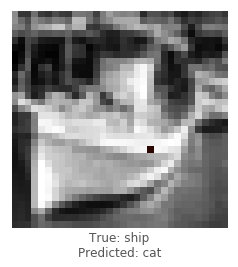

Attacking image 9826


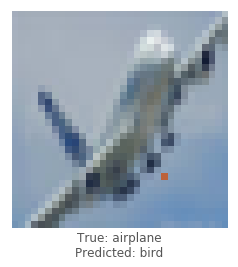

Attacking image 9186


/home/hyper/Documents/anaconda3/lib/python3.6/site-packages/scipy/optimize/_differentialevolution.py:533: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


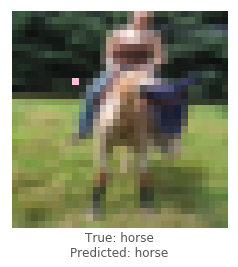

Attacking image 1991


KeyboardInterrupt: 

In [24]:
sample_count = 100
iterations = 30
mutation = 0.5
recombination = 1
stop_threshold = -0.01
callback = untargeted_callback

results = []
for model in models:
    imgs = correct_imgs[correct_imgs.name == model.name].img
    for pixel_count in range(1,4):
        samples = np.random.choice(imgs, sample_count)
        for i,img in enumerate(samples):
            population = 30 // pixel_count
            results += attack_untargeted_iteration(
                img, model, pixel_count, iterations,
                population, mutation, recombination, 
                stop_threshold, callback)

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'attack_image']
results = pd.DataFrame(results, columns=columns)

### Targeted Attack

In [ ]:
def attack_targeted_iteration(img, model, target, pixel_count=1, iterations=60,
                              population=20, mutation=0.5, recombination=0.7, 
                              stop_threshold=-0.01, callback=None):
    print('Attacking image', img, 'with target', target, class_names[target])
    
    args = x_test[img], target, model
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    attack = predict_targeted

    cb = None if callback == None else lambda x,convergence: callback(x, convergence, args)
    disp = callback == None
    
    res = differential_evolution(attack, bounds, args=args, maxiter=iterations, popsize=population, mutation=0.5, recombination=1, atol=stop_threshold, disp=disp, callback=cb)

    attack_image = perturb_image(res.x, x_test[img])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img][0]
    success = predicted_class == target

    plot_image(attack_image, actual_class, class_names, predicted_class)

    return [img, actual_class, predicted_class, success, predicted_probs, attack_image]

In [ ]:
def targeted_callback(x, convergence, args):
    img, target, model = args
    img_perturbed = perturb_image(x, img)
    confidence = model.predict_one(img_perturbed)
    prediction = np.argmax(confidence)
    print('Confidence:', confidence[target])
    if (prediction == target):
        return True # Do it this way because returning it directly will prevent early halting

In [ ]:
_ = attack_targeted_iteration(99, wide_resnet, 5, pixel_count=2, callback=targeted_callback)

In [ ]:
def attack_targeted(model, pixel_count=1, sample_count=100, iterations=30,
                      population=10, mutation=0.5, recombination=1, 
                      stop_threshold=-0.01, callback=targeted_callback):
    samples = np.random.choice(len(x_test), sample_count)
    
    results = []
    for i,img in enumerate(samples):
        print('Sample', i)
        for target in range(10):
            if target == y_test[img]:
                continue
            result = attack_targeted_iteration(
                img, model, target, pixel_count, iterations,
                population, mutation, recombination, 
                stop_threshold, callback)
            results.append(result)
            print()
            
    return pd.DataFrame(
        data=results,
        columns=['image_index', 'true_class', 'predicted_class', 'success', 'predicted_probs', 'attack_image']
    )

In [ ]:
targeted_results = attack_targeted(resnet)

In [ ]:
targeted_results

### Show some successful attacks

Plot the first 9 misclassified images

## Credits
 - Base code taken from https://github.com/09rohanchopra/cifar10
 - https://arxiv.org/pdf/1412.6806.pdf
 - https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
 - https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/06_CIFAR-10.ipynb
 - http://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/
 - https://parneetk.github.io/blog/cnn-cifar10/
 - https://github.com/dnlcrl/deep-residual-networks-pyfunt/blob/master/docs/CIFAR-10%20Experiments.ipynb